In [1]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   
from duration_processor import load_quiz_data
# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_61464/1443811771.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


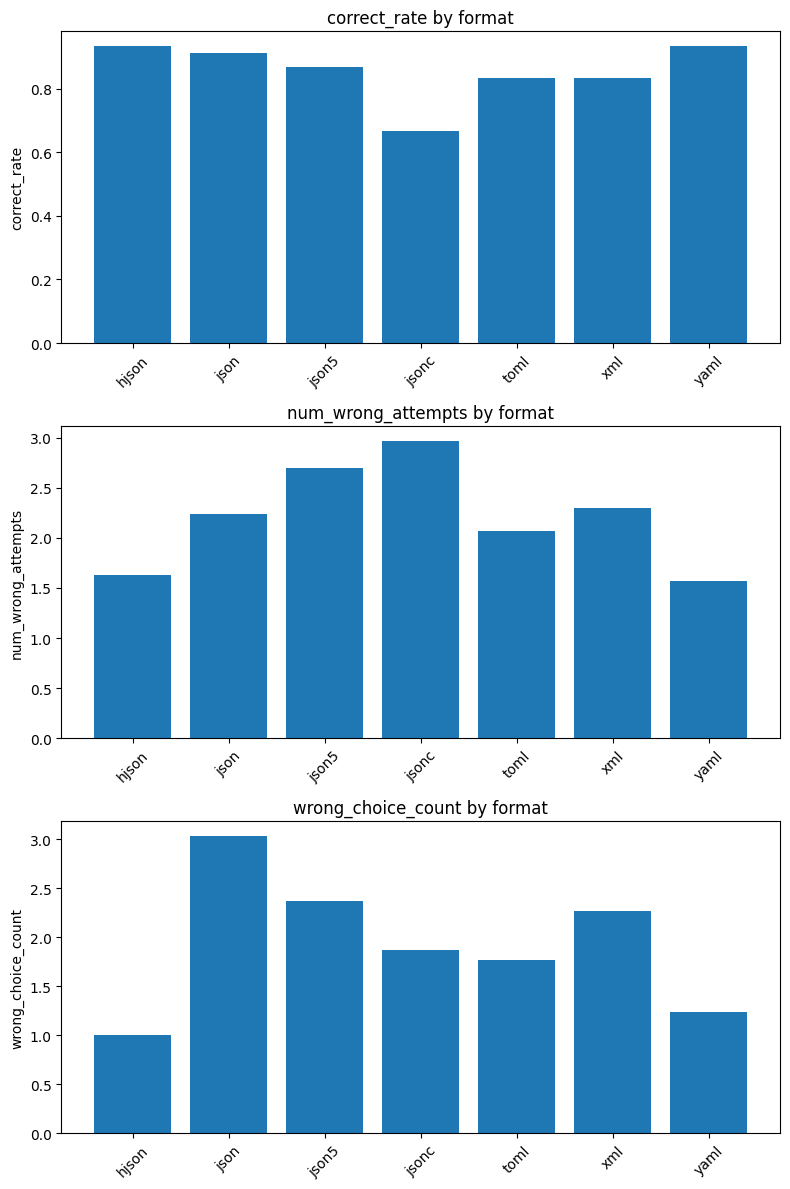

In [2]:
from quiz_evaluator import (
    evaluate_quiz_answers_from_tutorial,
    plot_quiz_metrics_by_group,
    test_quiz_metrics,
    process_quiz_metrics_per_participant
)

df_quiz = evaluate_quiz_answers_from_tutorial(all_data)

fig = plot_quiz_metrics_by_group(
    df_quiz,
    group_by='format',
    metrics=[
      'correct_rate',
      'num_wrong_attempts',
      'wrong_choice_count'
    ],
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)
fig.show()

In [3]:
# 1) Preprocess to per‐participant summary
df_part_summary, df_format_mean = process_quiz_metrics_per_participant(
    df_quiz,
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)

# 2) Test quiz metrics
results = test_quiz_metrics(
    df_part_summary,
    metrics=['correct_rate','num_wrong_attempts','wrong_choice_count'],
    alpha=0.05
)

# 3) View interpretations
for metric, info in results.items():
    print(info['interpretation'])
    if info['tukey'] is not None:
        print(info['tukey'].summary())


Metric 'correct_rate': Levene’s test p = 0.114 (homogeneous) variances. ANOVA p = 0.080 (≥ 0.05): no significant format differences.
Metric 'num_wrong_attempts': Levene’s test p = 0.289 (homogeneous) variances. ANOVA p = 0.036 (< 0.05): formats differ significantly. See Tukey HSD for pairwise contrasts.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 hjson   json    0.602 0.8457 -0.7805 1.9844  False
 hjson  json5   1.0667 0.2777 -0.3584 2.4917  False
 hjson  jsonc   1.3333 0.0824 -0.0917 2.7584  False
 hjson   toml   0.4333 0.9694 -0.9917 1.8584  False
 hjson    xml   0.6667 0.7964 -0.7584 2.0917  False
 hjson   yaml  -0.0667    1.0 -1.4917 1.3584  False
  json  json5   0.4647 0.9503 -0.9178 1.8472  False
  json  jsonc   0.7314 0.6877 -0.6511 2.1139  False
  json   toml  -0.1686 0.9998 -1.5511 1.2139  False
  json    xml   0.0647    1.0 -1.3178 1.4472  False
  json   yaml  -0.6

In [11]:
import pandas as pd

def summarize_quiz_significance(
    results: dict,
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    输入： test_quiz_metrics 返回的 results 字典
    输出： 一个 DataFrame，列包括：
      - metric: 指标名
      - method: 使用的检验方法（ANOVA 或 Kruskal–Wallis）
      - significant: True/False 是否有显著差异（p_value < alpha）
      - diff_pairs: 对于显著的指标，Tukey HSD 中 reject=True 的格式对列表
    并且在控制台打印出每个 metric 用的是哪种方法。
    """
    rows = []
    for metric, info in results.items():
        method = info['method']
        pval   = info['p_value']
        is_sig = pval < alpha

        # 打印 method 信息
        print(f"Metric '{metric}' 使用的测试方法：{method}")

        # 解析 diff_pairs（同之前）
        pairs = []
        if is_sig and method == 'ANOVA' and info.get('tukey') is not None:
            tbl = info['tukey'].summary().data[1:]
            for row in tbl:
                if row[-1] in (True, 'True'):
                    pairs.append(f"{row[0]} vs {row[1]}")

        rows.append({
            'metric':       metric,
            'method':       method,
            'significant':  is_sig,
            'diff_pairs':   pairs
        })

    df = pd.DataFrame(rows)
    return df


summary_df = summarize_quiz_significance(results)
print(summary_df)

Metric 'correct_rate' 使用的测试方法：ANOVA
Metric 'num_wrong_attempts' 使用的测试方法：ANOVA
Metric 'wrong_choice_count' 使用的测试方法：ANOVA
               metric method  significant                     diff_pairs
0        correct_rate  ANOVA        False                             []
1  num_wrong_attempts  ANOVA         True                             []
2  wrong_choice_count  ANOVA         True  [hjson vs json, json vs yaml]


In [16]:
df_part_summary

,participantId,format,correct_rate,num_wrong_attempts,wrong_choice_count
0,56cb8858edf8da000b6df354,hjson,1.0,0.0,0.0
1,57c357770e6a1f00015f6038,json,1.0,0.5,0.5
2,5b68c9eb87af310001584803,json5,1.0,1.5,1.0
3,5d30dfa68b1523000134878f,json,1.0,1.5,3.0
4,5d766978f47e6200019a2acf,yaml,1.0,1.0,0.5
...,...,...,...,...,...
102,67f1a4f8dd44e7cd5adffa29,json5,1.0,1.5,2.5
103,67f1c7bd6f1c4a3d8deae02f,toml,1.0,0.0,0.0
104,67f3619e16d4ca195fbd1bd0,yaml,1.0,1.5,0.5
105,67f5bb69760b211cdfe8021c,jsonc,0.5,2.5,0.0


In [20]:
import pingouin as pg


def games_howell_pairs(df, group_col, val_col, alpha=0.05):
    gh = pg.pairwise_gameshowell(df, dv=val_col, between=group_col)
    sig = gh.loc[gh['pval'] < alpha, ['A','B']].apply(lambda r: f"{r[0]} vs {r[1]}", axis=1)
    return sig.tolist()

def enrich_with_gameshowell_all(
    results: dict,
    df_summary: pd.DataFrame,
    group_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    对每个 metric，只要整体检验 p<alpha，就从原始 df_summary（参与者级长表）
    里取这一列，跑 Games–Howell，把结果挂到 results[metric]['gameshowell']。
    """
    for metric, info in results.items():
        if info['p_value'] < alpha:
            sub = df_summary[[group_col, metric]].dropna()
            info['gameshowell'] = games_howell_pairs(sub, group_col, metric, alpha)
        else:
            info['gameshowell'] = []
    return results


# 1. 先执行你的检验，得到 results
results = test_quiz_metrics(df_part_summary)

# 2. 用原始 df_summary 扩展 results
results = enrich_with_gameshowell_all(results, df_part_summary)

# 3. 查看输出
for metric, info in results.items():
    print(f"{metric}: 方法={info['method']}, p={info['p_value']:.3f}, "
          f"Games–Howell 显著对：{info['gameshowell']}")


correct_rate: 方法=ANOVA, p=0.080, Games–Howell 显著对：[]
num_wrong_attempts: 方法=ANOVA, p=0.036, Games–Howell 显著对：[]
wrong_choice_count: 方法=ANOVA, p=0.003, Games–Howell 显著对：['hjson vs json', 'hjson vs json5', 'hjson vs xml']


In [21]:
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway, kruskal
import pingouin as pg  # 如果要用 Welch ANOVA: pg.welch_anova

def choose_and_run_test(
    df: pd.DataFrame,
    group_col: str,
    val_col: str,
    alpha: float = 0.05
) -> dict:
    """
    1) 对每个组做 Shapiro-Wilk 正态性检验
    2) 对所有组做 Levene 方差齐性检验
    3) 根据结果决策：
       - 正态&齐方差 → ANOVA
       - 正态&异方差 → Welch ANOVA 或 Kruskal
       - 非正态         → Kruskal
    4) 返回各步 p 值和最终检验结果
    """
    # 1) 正态性检验
    normals = {}
    for grp, sub in df.groupby(group_col):
        stat, p_norm = shapiro(sub[val_col])
        normals[grp] = p_norm
        print(f"[Normality] {grp}: W={stat:.3f}, p={p_norm:.3f}")

    # 2) 方差齐性
    groups = [sub[val_col].values for _, sub in df.groupby(group_col)]
    w_stat, p_levene = levene(*groups)
    print(f"[Levene] W={w_stat:.3f}, p={p_levene:.3f}")

    # 3) 决策流程
    non_normal = [g for g,p in normals.items() if p <= alpha]
    if non_normal:
        method = 'Kruskal–Wallis'
        stat, p_main = kruskal(*groups)
        print(f"=> 因为组 {non_normal} 正态性不满足，使用 Kruskal–Wallis: H={stat:.3f}, p={p_main:.3f}")
    else:
        if p_levene > alpha:
            method = 'ANOVA'
            stat, p_main = f_oneway(*groups)
            print(f"=> 正态且齐方差，使用 One-way ANOVA: F={stat:.3f}, p={p_main:.3f}")
        else:
            # 这里示例用 Welch ANOVA，也可退回 Kruskal
            method = 'Welch ANOVA'
            welch = pg.welch_anova(dv=val_col, between=group_col, data=df)
            stat = welch['F'][0]
            p_main = welch['p-unc'][0]
            print(f"=> 正态但方差不齐，使用 Welch ANOVA: F={stat:.3f}, p={p_main:.3f}")

    return {
        'normality_p': normals,
        'levene': (w_stat, p_levene),
        'method': method,
        'stat': stat,
        'p_value': p_main
    }

# 假设 df_summary 是参与者级长表，含列 ['format','num_wrong_attempts',...]
sub = df_part_summary[['format','num_wrong_attempts']].dropna()
res = choose_and_run_test(sub, group_col='format', val_col='num_wrong_attempts')


[Normality] hjson: W=0.936, p=0.330
[Normality] json: W=0.936, p=0.274
[Normality] json5: W=0.914, p=0.157
[Normality] jsonc: W=0.951, p=0.541
[Normality] toml: W=0.903, p=0.105
[Normality] xml: W=0.930, p=0.271
[Normality] yaml: W=0.849, p=0.017
[Levene] W=1.248, p=0.289
=> 因为组 ['yaml'] 正态性不满足，使用 Kruskal–Wallis: H=12.776, p=0.047


In [22]:
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

def generate_metrics_report(
    df: pd.DataFrame,
    metrics: list = None,
    group_col: str = 'format',
    alpha: float = 0.05
):
    """
    对每个 metric（default ['correct_rate','num_wrong_attempts','wrong_choice_count']）：
      1) Shapiro-Wilk 检验正态性
      2) Levene 检验方差齐性
      3) 根据结果运行 One-way ANOVA / Welch ANOVA / Kruskal–Wallis
      4) 如果 p<alpha，再做事后比较（ANOVA→Tukey, 否则→Games–Howell）
    并打印简洁英文报告。
    """
    if metrics is None:
        metrics = ['correct_rate', 'num_wrong_attempts', 'wrong_choice_count']
    
    for metric in metrics:
        if metric not in df.columns:
            print(f"Warning: Metric '{metric}' not found. Skipping.\n")
            continue
        
        sub = df[[group_col, metric]].dropna()
        groups = [g[metric].values for _, g in sub.groupby(group_col)]
        
        # 1) 正态性检验
        non_normal = []
        for name, g in sub.groupby(group_col):
            stat, p_norm = shapiro(g[metric])
            if p_norm <= alpha:
                non_normal.append(name)
        
        # 2) 方差齐性检验
        wl, p_levene = levene(*groups)
        
        # 3) 决定主检验
        if non_normal:
            method = 'Kruskal–Wallis'
            stat, p_main = kruskal(*groups)
        else:
            if p_levene > alpha:
                method = 'One-way ANOVA'
                stat, p_main = f_oneway(*groups)
            else:
                method = 'Welch ANOVA'
                welch = pg.welch_anova(dv=metric, between=group_col, data=sub)
                stat = welch['F'][0]
                p_main = welch['p-unc'][0]
        
        # 4) 打印报告
        print(f"Metric '{metric}': used {method} (p = {p_main:.3f}).", end=' ')
        if p_main < alpha:
            print("Significant difference detected.", end=' ')
            # 事后比较
            if method == 'One-way ANOVA':
                tukey = pairwise_tukeyhsd(endog=sub[metric], groups=sub[group_col], alpha=alpha)
                # summary().data: header + rows
                sig_pairs = [
                    f"{r[0]} vs {r[1]}"
                    for r in tukey.summary().data[1:]
                    if r[-1] in (True, 'True')
                ]
                if sig_pairs:
                    print("Tukey HSD shows differences between:", ", ".join(sig_pairs), end='.')
                else:
                    print("But no pairwise differences passed Tukey HSD.", end='.')
            else:
                gh = pg.pairwise_gameshowell(sub, dv=metric, between=group_col)
                sig_pairs = gh.loc[gh['pval'] < alpha, ['A','B']] \
                              .apply(lambda r: f"{r[0]} vs {r[1]}", axis=1) \
                              .tolist()
                if sig_pairs:
                    print("Games–Howell shows differences between:", ", ".join(sig_pairs), end='.')
                else:
                    print("But no pairwise differences passed Games–Howell.", end='.')
        else:
            print("No significant differences found across groups.", end='.')
        
        print("\n")  # 空行分隔

# === 用法示例 ===
# generate_metrics_report(df_summary)
generate_metrics_report(df_part_summary)

Metric 'correct_rate': used Kruskal–Wallis (p = 0.091). No significant differences found across groups..

Metric 'num_wrong_attempts': used Kruskal–Wallis (p = 0.047). Significant difference detected. But no pairwise differences passed Games–Howell..

Metric 'wrong_choice_count': used Kruskal–Wallis (p = 0.002). Significant difference detected. Games–Howell shows differences between: hjson vs json, hjson vs json5, hjson vs xml.



/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_41946/3471488952.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


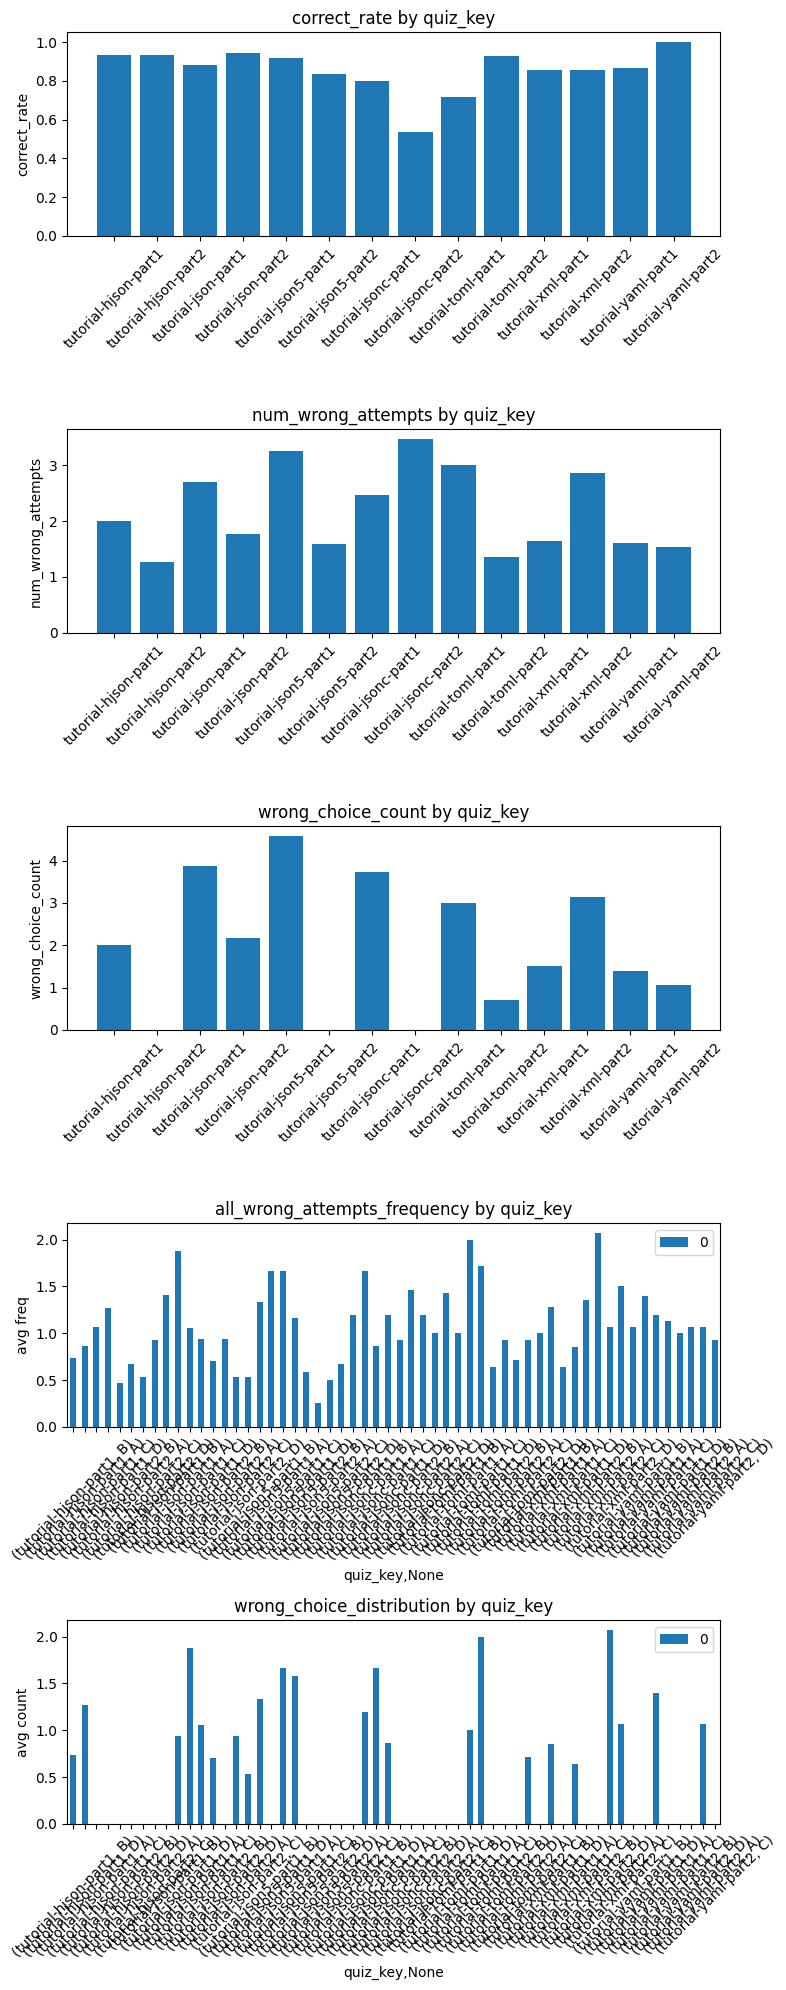

In [5]:
fig = plot_quiz_metrics_by_group(
    df_quiz,
    group_by='quiz_key',
    metrics=[
      'correct_rate',
      'num_wrong_attempts',
      'wrong_choice_count',
      'all_wrong_attempts_frequency',
      'wrong_choice_distribution'
    ],
    format_list=['json', 'xml', 'hjson', 'yaml','jsonc', 'json5', 'toml']
)
fig.show()


=== correct_rate (Kruskal–Wallis, p=0.091) ===
Post-hoc results:
Empty DataFrame
Columns: [group1, group2, p_value, significant]
Index: []

=== num_wrong_attempts (Kruskal–Wallis, p=0.047) ===
Post-hoc results:
     group1  group2   p_value  significant
0         0       A       NaN        False
1         1       A       NaN        False
2         2       A       NaN        False
3         3       A       NaN        False
4         4       A       NaN        False
..      ...     ...       ...          ...
205      16  hedges  0.516660        False
206      17  hedges  1.078490        False
207      18  hedges -0.156619         True
208      19  hedges  0.334102        False
209      20  hedges  0.609808        False

[210 rows x 4 columns]

=== wrong_choice_count (Kruskal–Wallis, p=0.002) ===
Post-hoc results:
     group1  group2   p_value  significant
0         0       A       NaN        False
1         1       A       NaN        False
2         2       A       NaN        False
3   

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


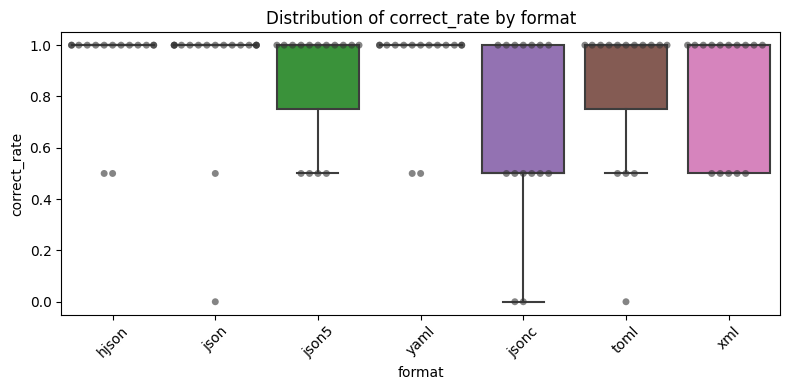

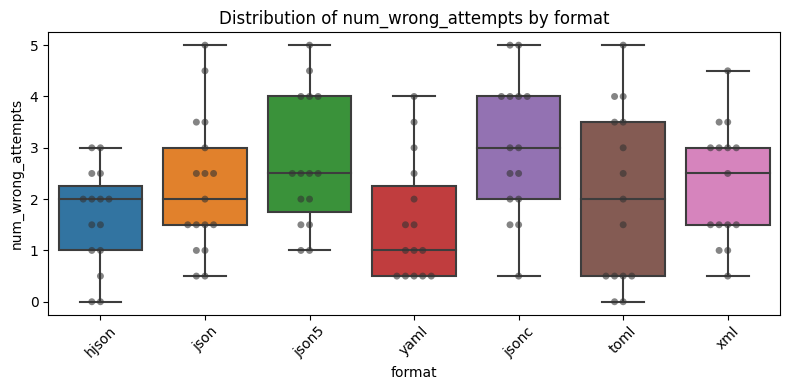

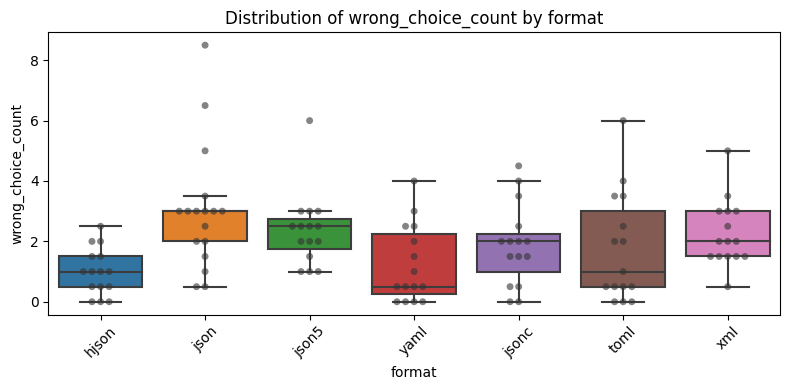

In [25]:
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

def test_metrics_by_format(
    df: pd.DataFrame,
    metrics: list = None,
    group_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    For each metric in `metrics`, runs:
      1) Shapiro-Wilk normality per group
      2) Levene test for equal variances
      3) One-way ANOVA if normal & homoscedastic,
         Welch ANOVA if normal & heteroscedastic,
         Kruskal–Wallis otherwise
      4) Tukey HSD (if ANOVA & p<alpha) or Games–Howell (otherwise & p<alpha)
    Returns a dict:
      metric -> {
        'normality': {group: p_norm, ...},
        'levene': (W, p_levene),
        'method': ...,
        'stat': ...,
        'p_value': ...,
        'posthoc': DataFrame of pairwise pvals and significance,
        'anova_table': DataFrame (for ANOVA/Welch ANOVA only)
      }
    """
    if metrics is None:
        metrics = ['correct_rate', 'num_wrong_attempts', 'wrong_choice_count']

    results = {}
    for m in metrics:
        if m not in df.columns:
            continue
        sub = df[[group_col, m]].dropna()
        # 1) Normality
        normality = {}
        for g, grp in sub.groupby(group_col):
            _, p_norm = shapiro(grp[m])
            normality[g] = p_norm
        # 2) Levene
        groups = [grp[m].values for _, grp in sub.groupby(group_col)]
        W, p_levene = levene(*groups)
        # 3) Choose test
        if any(p <= alpha for p in normality.values()):
            method = 'Kruskal–Wallis'
            stat, p_main = kruskal(*groups)
        else:
            if p_levene > alpha:
                method = 'ANOVA'
                stat, p_main = f_oneway(*groups)
            else:
                method = 'Welch ANOVA'
                welch = pg.welch_anova(dv=m, between=group_col, data=sub)
                stat = welch['F'][0]
                p_main = welch['p-unc'][0]
        # 4) Post-hoc

        if p_main < alpha:
            if method == 'ANOVA':
                post = pairwise_tukeyhsd(endog=sub[m], groups=sub[group_col], alpha=alpha)
                post_df = pd.DataFrame(post.summary().data[1:], 
                                       columns=post.summary().data[0])
            else:
                # Games–Howell
                gh = pg.pairwise_gameshowell(sub, dv=m, between=group_col)
                gh_long = (
                    gh
                    .reset_index()
                    .melt(id_vars='index', 
                        var_name='group2',
                        value_name='p_value')  # 改名为 p_value
                    .rename(columns={'index': 'group1'})
                )
                # 强制转成 float，不能转的变成 NaN
                gh_long['p_value'] = pd.to_numeric(gh_long['p_value'], errors='coerce')
                gh_long['significant'] = gh_long['p_value'] < alpha

                post_df = (
                    gh_long[gh_long['group1'] != gh_long['group2']]
                    .drop_duplicates(subset=['group1','group2'])
                )
        else:
            post_df = pd.DataFrame(columns=['group1','group2','p_value','significant'])

        # ANOVA table
        if method in ('ANOVA','Welch ANOVA'):
            model = ols(f'{m} ~ C({group_col})', data=sub).fit()
            anova_tbl = anova_lm(model, typ=2)
        else:
            anova_tbl = pd.DataFrame()

        results[m] = {
            'normality': normality,
            'levene':        (W, p_levene),
            'method':        method,
            'stat':          stat,
            'p_value':       p_main,
            'posthoc':       post_df,
            'anova_table':   anova_tbl
        }

    return results

def extract_outliers(
    df: pd.DataFrame,
    group_col: str,
    value_col: str
) -> pd.DataFrame:
    """
    Identify outliers per group using 1.5*IQR rule.
    """
    out = []
    for g, grp in df.groupby(group_col):
        q1, q3 = grp[value_col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (grp[value_col] < lb) | (grp[value_col] > ub)
        tmp = grp[mask].copy()
        tmp['outlier_group'] = g
        tmp['lower_bound'], tmp['upper_bound'] = lb, ub
        out.append(tmp)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

def visualize_metrics(
    df: pd.DataFrame,
    metrics: list = None,
    group_col: str = 'format'
):
    """
    Draws a boxplot + swarmplot for each metric.
    """
    if metrics is None:
        metrics = ['correct_rate', 'num_wrong_attempts', 'wrong_choice_count']

    for m in metrics:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=group_col, y=m, data=df, showfliers=False)
        sns.swarmplot(x=group_col, y=m, data=df, color='.2', alpha=0.6)
        plt.title(f'Distribution of {m} by {group_col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# ========== Example Usage ==========

# df_summary: your participant-level DataFrame with columns
# ['participantId','format','correct_rate','num_wrong_attempts','wrong_choice_count',...]
results = test_metrics_by_format(df_part_summary)

# Print ANOVA tables and summary
for metric, info in results.items():
    print(f"\n=== {metric} ({info['method']}, p={info['p_value']:.3f}) ===")
    if not info['anova_table'].empty:
        print("ANOVA table:")
        print(info['anova_table'])
    print("Post-hoc results:")
    print(info['posthoc'])

# Detect outliers on one metric
outliers = extract_outliers(df_part_summary, 'format', 'correct_rate')
print("\nOutliers in 'num_wrong_attempts':")
print(outliers)

# Plot distributions
visualize_metrics(df_part_summary)


In [33]:
outliers = extract_outliers(df_part_summary, 'format', 'wrong_choice_count')
print("\nOutliers in 'wrong_choice_count':")
print(outliers)


Outliers in 'wrong_choice_count':
              participantId format  correct_rate  num_wrong_attempts  \
0  60f1f1d4ac991a259b83f603   json           1.0                 4.5   
1  667ac09492ea0caadf488520   json           0.0                 5.0   
2  67e571bef6af7ecd9c29ad72   json           1.0                 3.5   
3  67d188bcc201cc08eac23f92  json5           0.5                 4.0   
4  66781db404eab5e142f849d9  jsonc           0.5                 4.0   

   wrong_choice_count outlier_group  lower_bound  upper_bound  
0                 6.5          json        0.500        4.500  
1                 8.5          json        0.500        4.500  
2                 5.0          json        0.500        4.500  
3                 6.0         json5        0.250        4.250  
4                 4.5         jsonc       -0.875        4.125  
